# Showcasing of AMBER utilizing synthetic neutron scattering data

In [1]:
import numpy as np
from AMBER.background import background
import matplotlib.pyplot as plt

## Generate signal data
The data for this tutorial is generated using the expected neutron scattering signal in an inelastic exmperiment measuring MnF$_2$. The dispersion relation, i.e. the energy at a give (H,K,L) position is given by the analytical formula [Yamany et al. 2010](https://www.doi.org/10.1139/P10-081):

$$\omega(H,K,L) = \sqrt{\left(2S z_2 J_2+D+2 z_1 S J_1 \sin{L \pi}^2\right)^2-\left(2 S z_2 J_2 \cos(H \pi)\cos(K \pi) \cos(L \pi)\right)^2}$$

In the above $J_1$, $J_2$, and $D$ are the magnetic coupling strengths and single-ion anisotropy which determine the amplitude of the dispersion. The parameters $S = 5/2$, $z_1 = 2$, and $z_2 = 8$ corresponds the the size of the magnetic spin, and the number of nearest and next-nearest neighbours in the MnF$_2$ lattice. 

From the above equation, the imporant fact is that it depends on the 3D vector $Q = (H,K,L)$. For simplicity, we assume that $K$ is zero and thus reduce the data to 3D, i.e. $(H,L,\omega)$

Due to how neutron scattering experiments function, the above dispersion will not be infinitely thin but rather extended. Here, this is replicated by a simple gaussian smearing along $\omega$


In [2]:
# Define parameters, dispersion, and Smearing
S = 5/2
z1 = 2
z2 = 8

def SpinWave(Q,J1,J2,D):
    return np.sqrt(np.power(2*S*z2*J2+D+2*z1*S*J1*np.sin(Q[2]*np.pi)**2,2.0)-
    
            np.power(2*S*z2*J2*np.cos(Q[0]*np.pi)*np.cos(Q[1]*np.pi)*np.cos(Q[2]*np.pi),2.0))

def Intensity(H,K,L,E):
    sigmaE = 0.25
    omega = SpinWave(np.array([H,K,L]),  J1=0.0354,J2=0.1499,D=0.131 )
    I = np.exp(-np.power(omega-E,2.0)/(2*sigmaE**2))
    
    return I

## Define 3D grid domain

The input to AMBER is a 3D cube of intensities which is define below

In [4]:
# Data will ge simulated along H and L but with K = 0

h = np.linspace(-0.1,2.1,101)
k = 0
l = np.linspace(-0.1,2.1,101)

# Choose a sufficient energy range
e = np.linspace(0.5,8,61)

# Generate the grid upon which the dispersion is calculated

H,L,E = np.meshgrid(h,l,e)
K = np.zeros_like(H)

# Intensities are calculated with the smearing and scaled
I = 30*Intensity(H,K,L,E)

# Poisson noice is added to the intensity
I = np.random.poisson(I).astype(float)

### Introduction of NaN-values

Triple axis instruments cannot measure all lengths of $Q$. this we can mimic by exchaning the intensity at these points by NaNs

In [5]:
QLength = np.linalg.norm([H,L],axis=0)

I[QLength<0.35] = np.nan
I[QLength>2.5] = np.nan


### Add background
The main feature of AMBER is the background segmentation, which requires the data to have a background. As describe in the [article](???), background is assumed to:

- Rotation independence of the background.
- Smooth change of background along energy and $|\vec{Q}|$.
- The signal is sparse but continuous in energy and $|\vec{Q}|$.

In the following, a background is generated with a higher amplitude for low and high $|\vec{Q}|$ mimicing instrumental background artefacts from triple axis neutron experiments - these corresponds to the direct beam contribution and to increased background at larger scattering angles. 

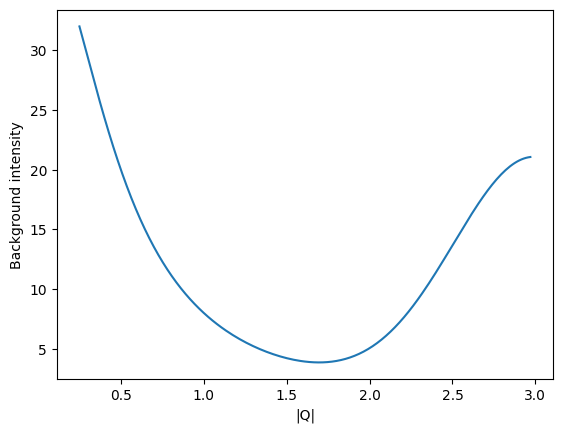

In [6]:
# Background definition
def background_simulation(q,amplitude,gamma,mu,amplitude2,gamma2):
    return amplitude*((gamma/(q**2+gamma**2))+amplitude2*np.exp(-np.power(q-mu,2.0)/(2*gamma2**2)))


Q = np.linalg.norm([H,K,L],axis=0)

# Choose suitable valies
gamma = 0.5
mu = 3.0
amplitude = 20
amplitude2 = 1.0
gamma2 = 0.5

# Generate an example of the background for visual inspection
q = np.linspace(0.25,Q.max(),201)
bg_test = background_simulation(q,amplitude,gamma,mu,amplitude2,gamma2)

# display background amplitude
fig,ax = plt.subplots()
ax.plot(q,bg_test)
ax.set_xlabel('|Q|')
ax.set_ylabel('Background intensity')


## Add background to data
bg_tmp = background_simulation(Q,amplitude,gamma,mu,amplitude2,gamma2)

I+=np.random.poisson(bg_tmp)

## Plot a constant energy plot
The now background affected data is plotted to show a "before" picture. This is done by choosing a specific energy ($\omega \sim 4.5$ meV) and plotting the intensity as a color map

Text(0, 0.5, 'L [r.l.u.]')

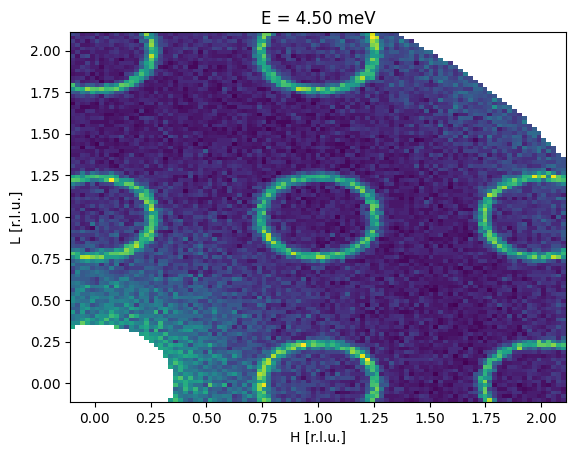

In [27]:
fig,ax = plt.subplots()

# Find the closest energy slice
energy = 4.5
EIdx = np.argmin(np.abs(E-energy))
ax.pcolormesh(H[:, :, EIdx], L[:, :, EIdx], I[:, :, EIdx], vmin=0, vmax = 50)

ax.set_title('E = {:.2f} meV'.format(e[EIdx]))
ax.set_xlabel('H [r.l.u.]')
ax.set_ylabel('L [r.l.u.]')

## Plot a constant H map

Text(0, 0.5, 'E [meV]')

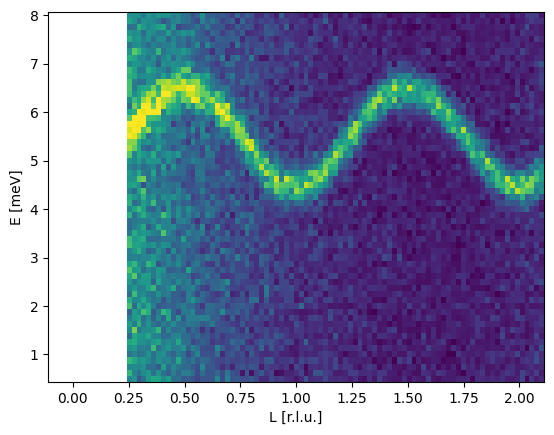

In [28]:
fig,ax = plt.subplots()

h_value = 0.25
HIdx = np.argmin(np.abs(h-h_value))
ax.pcolormesh(L[:, HIdx, :],E[:, HIdx, :],I[:, HIdx, :], vmin=0, vmax=50)

ax.set_xlabel('L [r.l.u.]')
ax.set_ylabel('E [meV]')


## Run denoising algorithm

In [42]:
# Initialize the AMBER background object

AMBER = background(dtype=np.float32)

# Set the grid sizes
AMBER.set_gridcell_size(dqx = 0.022, dqy = 0.022, dE = 0.125)

# Alternatively these can be set from the h, l, and e arrays like
# AMBER.set_volume_from_limits([h[0],l[0],e[0]],[h[-1],l[-1],e[-1]],)

# Input the data
AMBER.set_binned_data(h, l, e, I)

bins = int((q.max()-q.min())/0.022)

# define maximum radius and number of bins
AMBER.set_radial_bins(q.max(),n_bins=bins)

### Set algorithm parameters ($\lambda, \beta, \mu$)

lambda and mu will be determined as described in the paper and we select beta using cross validation

beta_ is selected using cross validation, i.e. mask out the top q quantile of intensity. The beta value for the lowest Root-Mean-Square-Error is then chosen

In [15]:

lambda_tmp = AMBER.MAD_lambda()
mu_tmp = AMBER.mu_estimator()


beta_range_tmp = np.array([0.1,1.0,10.0,100.0,200.0,300.0,400.0,500.0])
rmse = AMBER.cross_validation(q=0.3,beta_range= beta_range_tmp, lambda_=lambda_tmp, mu_=mu_tmp,n_epochs=15,verbose=False)


beta_tmp = beta_range_tmp[np.argmin(rmse)]

Test - ( 0.1 )
RMSE - ( 4.4478 0.1 55.50635141061015 ) :  3.4844415
Test - ( 1.0 )
RMSE - ( 4.4478 1.0 55.50635141061015 ) :  3.4835355
Test - ( 10.0 )
RMSE - ( 4.4478 10.0 55.50635141061015 ) :  3.4762373
Test - ( 100.0 )
RMSE - ( 4.4478 100.0 55.50635141061015 ) :  3.4504814
Test - ( 200.0 )
RMSE - ( 4.4478 200.0 55.50635141061015 ) :  3.443771
Test - ( 300.0 )
RMSE - ( 4.4478 300.0 55.50635141061015 ) :  3.4432797
Test - ( 400.0 )
RMSE - ( 4.4478 400.0 55.50635141061015 ) :  3.4455476
Test - ( 500.0 )
RMSE - ( 4.4478 500.0 55.50635141061015 ) :  3.44926


### Run the denoising algorithm using the parameters obtained using the heuristic

In [18]:
# set number of epochs
n_epochs = 20

AMBER.denoising(AMBER.Ygrid,lambda_tmp,beta_tmp,mu_tmp,n_epochs,verbose=True) 

 Iteration  1
 Loss function:  24608190.0
 Iteration  2
 Loss function:  18320822.0
 Iteration  3
 Loss function:  15589522.0
 Iteration  4
 Loss function:  14332520.0
 Iteration  5
 Loss function:  13731277.0
 Iteration  6
 Loss function:  13459373.0
 Iteration  7
 Loss function:  13346343.0
 Iteration  8
 Loss function:  13302241.0
 Iteration  9
 Loss function:  13285422.0
 Iteration  10
 Loss function:  13278990.0
 Iteration  11
 Loss function:  13276512.0
 Iteration  12
 Loss function:  13275553.0
 Iteration  13
 Loss function:  13275184.0
 Iteration  14
 Loss function:  13275036.0
 Iteration  15
 Loss function:  13274984.0
 Iteration  16
 Loss function:  13274959.0
 Iteration  17
 Loss function:  13274950.0
 Iteration  18
 Loss function:  13274948.0


## Compute substracted signal

In [33]:
# The subtracted signal is given by

Y_sub = AMBER.Ygrid - AMBER.b_grid
Y_back = AMBER.b_grid

# reshape the data to fit 
Y_sub = Y_sub.reshape(AMBER.E_size,AMBER.Qx_size,AMBER.Qy_size).T
Y_back = Y_back.reshape(AMBER.E_size,AMBER.Qx_size,AMBER.Qy_size).T

# reshape the observation
Y_obs =  AMBER.Ygrid.reshape(AMBER.E_size,AMBER.Qx_size,AMBER.Qy_size).T

## Display substracted signal

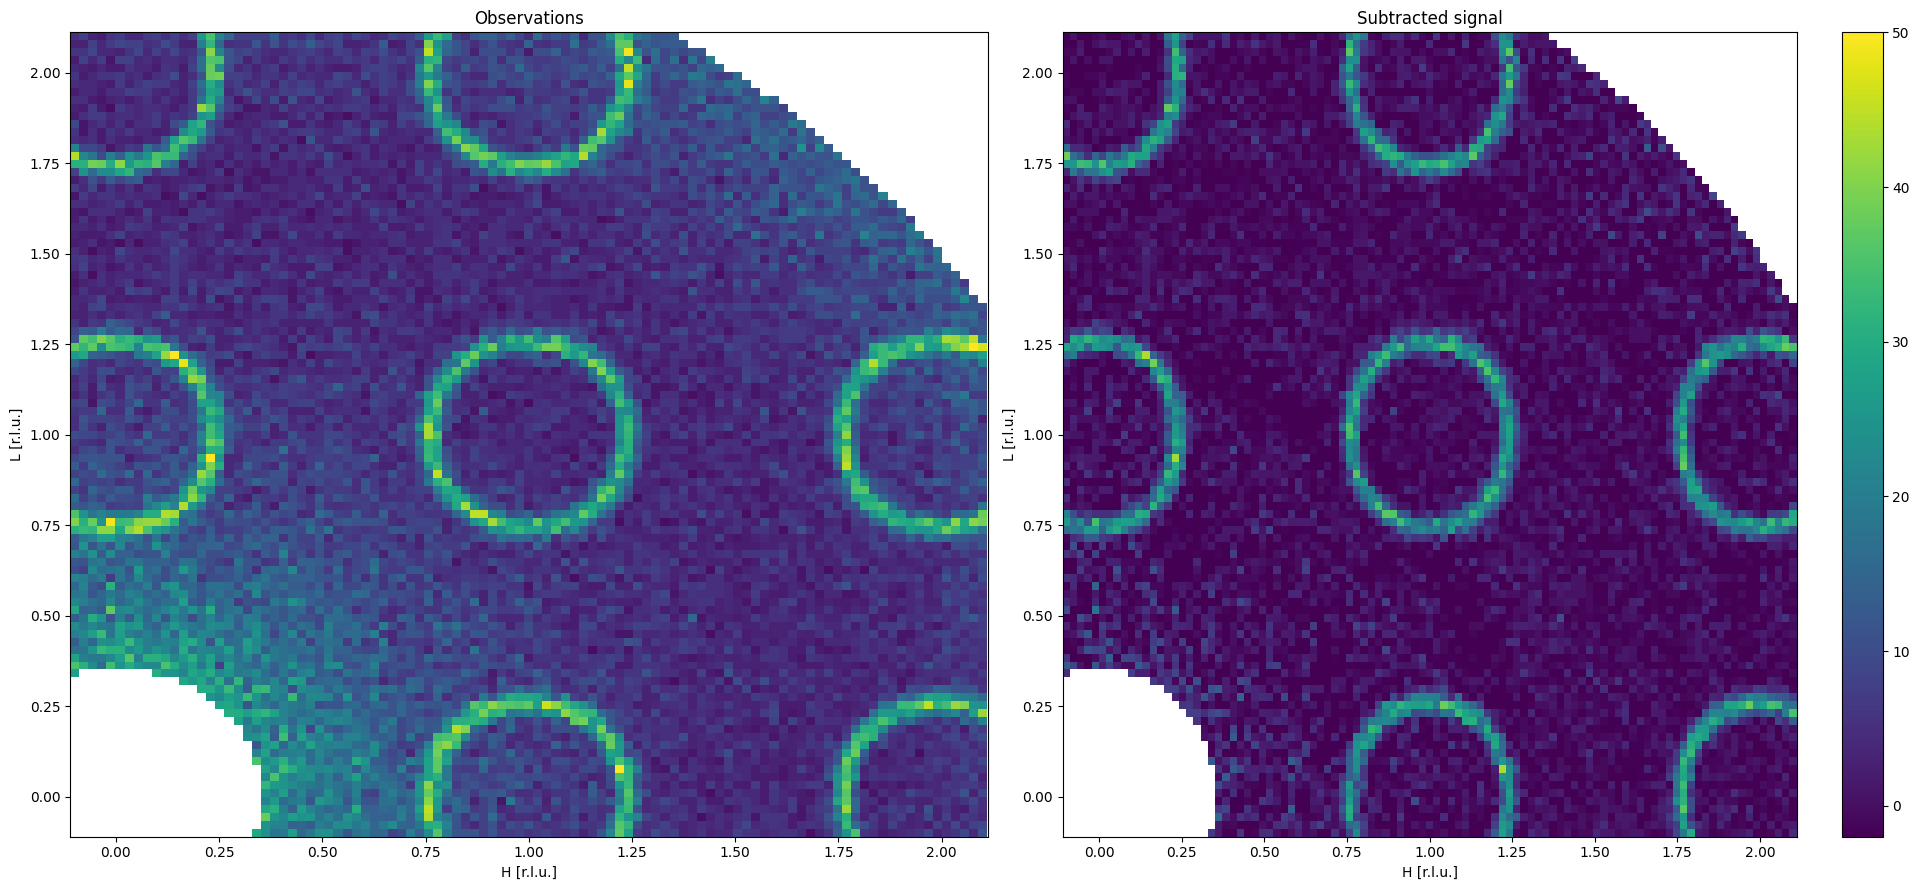

In [46]:
# reshape the observation
Y_obs =  AMBER.Ygrid.reshape(AMBER.E_size,AMBER.Qx_size,AMBER.Qy_size).T


fig0 = plt.figure(figsize=(20, 9))

# Plot 1: Observations Y
ax0 = fig0.add_subplot(1, 2, 1)

energy = 4.5
EIdx = np.argmin(np.abs(E-energy))
ax0.pcolormesh(H[:,:,EIdx],L[:,:,EIdx],Y_obs[:,:,EIdx],vmin=-2,vmax=50)

ax0.set_xlabel('H [r.l.u.]')
ax0.set_ylabel('L [r.l.u.]')
ax0.set_title('Observations')

# Plot 2: Subtracted Y
ax1 = fig0.add_subplot(1, 2, 2)

energy = 4.5
EIdx = np.argmin(np.abs(E-energy))
p = ax1.pcolormesh(H[:,:,EIdx],L[:,:,EIdx],Y_sub[:,:,EIdx],vmin=-2,vmax=50)

ax1.set_xlabel('H [r.l.u.]')
ax1.set_ylabel('L [r.l.u.]')
ax1.set_title('Subtracted signal')

fig0.colorbar(p)
plt.tight_layout()
plt.show()


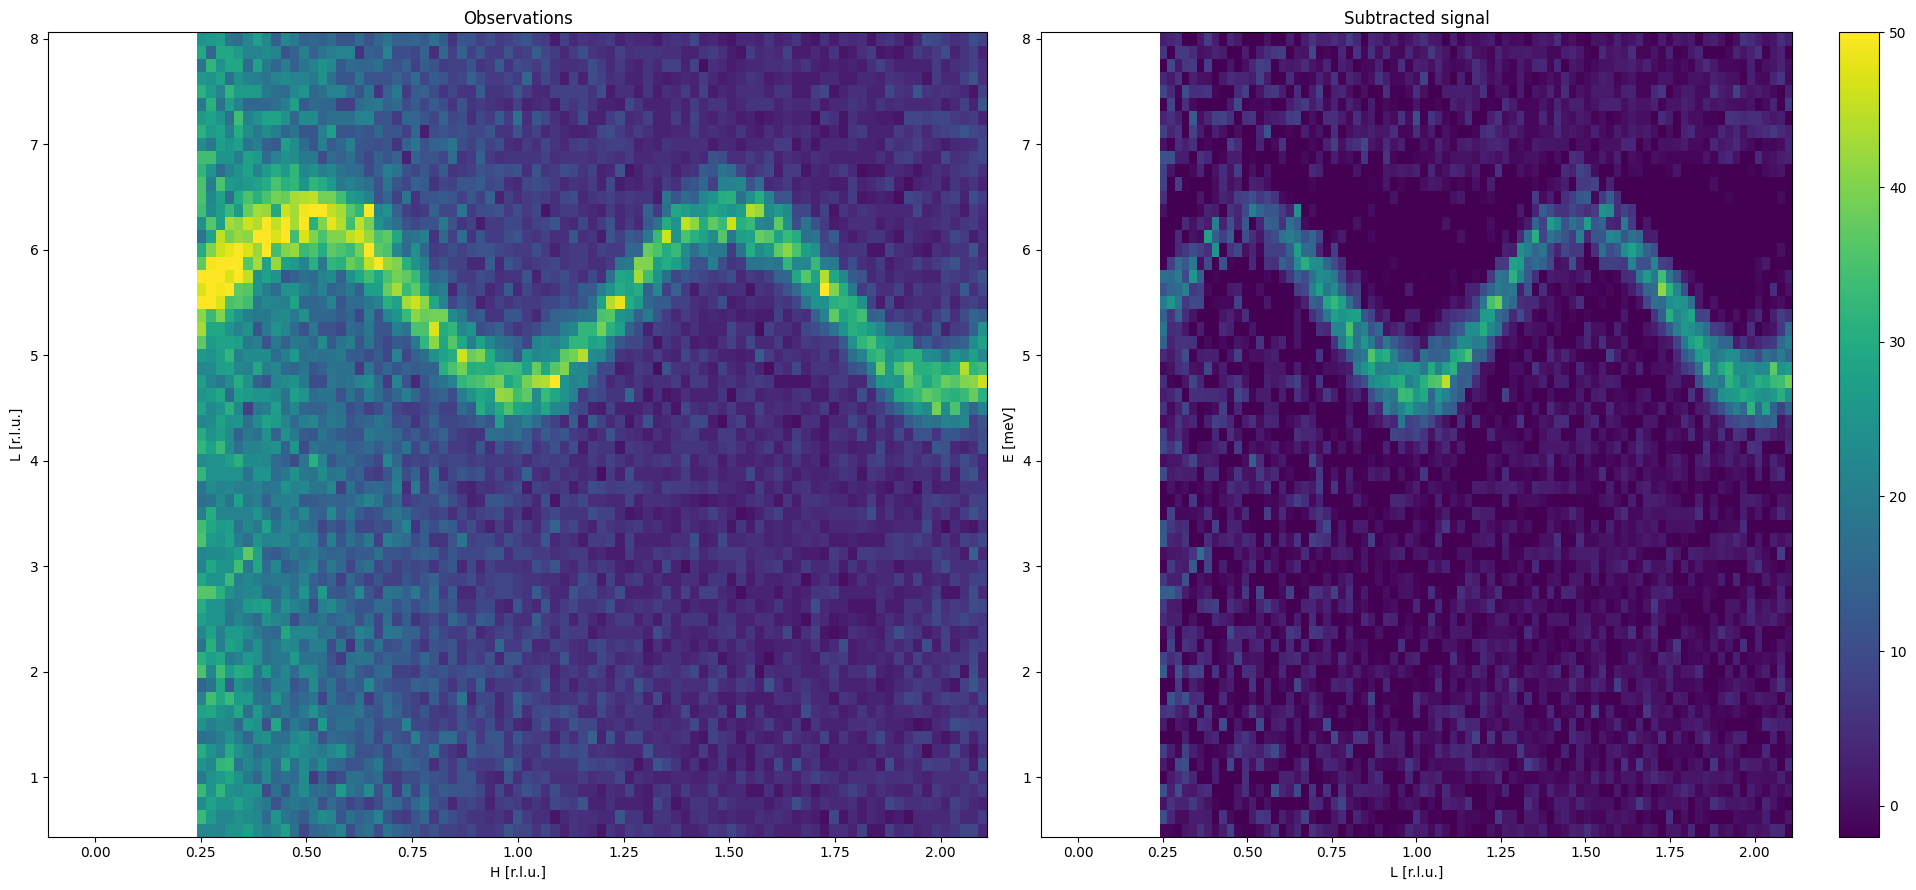

In [45]:
fig0 = plt.figure(figsize=(20, 9))

# Plot 1: Observations Y
ax0 = fig0.add_subplot(1, 2, 1)

h_value = 0.25
HIdx = np.argmin(np.abs(h-h_value))
ax0.pcolormesh(L[:,HIdx,:],E[:,HIdx,:],Y_obs[:,HIdx,:],vmin=-2,vmax=50)

ax0.set_xlabel('H [r.l.u.]')
ax0.set_ylabel('L [r.l.u.]')
ax0.set_title('Observations')

# Plot 2: Subtracted Y
ax1 = fig0.add_subplot(1, 2, 2)


HIdx = np.argmin(np.abs(h-h_value))
p = ax1.pcolormesh(L[:,HIdx,:],E[:,HIdx,:],Y_sub[:,HIdx,:],vmin=-2,vmax=50)

ax1.set_xlabel('L [r.l.u.]')
ax1.set_ylabel('E [meV]')
ax1.set_title('Subtracted signal')

fig0.colorbar(p)

plt.tight_layout()
plt.show()

## Compare the signal with the subtracted signal in a 1D cut

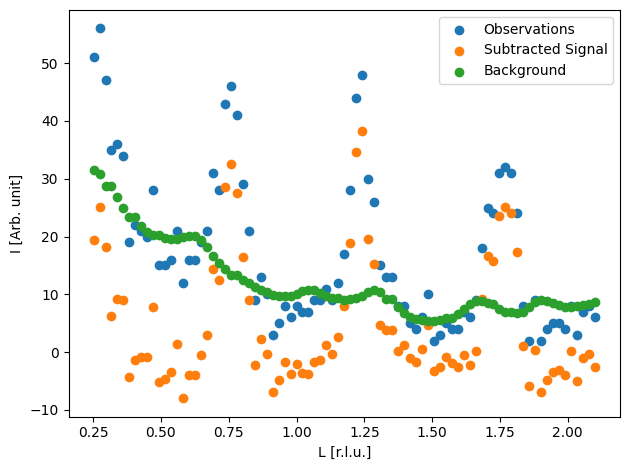

In [41]:
fig0 = plt.figure()

# Plot 1: Observations Y
ax0 = fig0.add_subplot(1, 1, 1)

h_value = 0.25
e_value = 5.5 # meV
EIdx = np.argmin(np.abs(e-e_value))
HIdx = np.argmin(np.abs(h-h_value))
ax0.scatter(L[:,HIdx,EIdx],Y_obs[:,HIdx,EIdx],label='Observations')
ax0.scatter(L[:,HIdx,EIdx],Y_sub[:,HIdx,EIdx],label='Subtracted Signal')
ax0.scatter(L[:,HIdx,EIdx],Y_back[:,HIdx,EIdx],label='Background')



ax0.set_xlabel('L [r.l.u.]')
ax0.set_ylabel('I [Arb. unit]')
ax0.legend()


plt.tight_layout()
plt.show()